# TCGA-BRCA RNA-seq → PAM50 Subtyping (Preliminary)

**Objective**  
Demonstrate an end-to-end RNA-seq processing and intrinsic subtyping pipeline
as groundwork for image-based breast cancer subtype prediction.

**Dataset**
- TCGA-BRCA
- RNA-seq (STAR – Counts)
- Subset: n = 15 (pipeline validation)


## Pipeline Overview

1. Query TCGA via GDC client for RNA-seq data   
2. Download RNA-seq STAR-Counts files  
3. Build gene × sample expression matrix  
4. Map Ensembl IDs → gene symbols  
5. Apply PAM50 intrinsic subtyping (genefu)  
6. Save labels and figures for downstream modeling


In [7]:
from pathlib import Path
import os

# Robustly locate repo root (works regardless of notebook location)
repo = Path(os.getcwd()).resolve()
while repo != repo.parent and not (repo / "data").exists():
    repo = repo.parent

assert (repo / "data").exists(), "Could not locate repo root"

repo


WindowsPath('D:/Projects/histo-to-omics-framework')

In [8]:
raw_dir = repo / "data" / "raw" / "gdc" / "brca_star_counts_pt_15"

print("Raw dir exists:", raw_dir.exists())
print("Number of samples:", len(list(raw_dir.iterdir())))


Raw dir exists: True
Number of samples: 15


In [9]:
[p.name for p in raw_dir.iterdir()]


['1ace2a0c-773d-45b5-8fd6-968c88731bbb',
 '2d5b0962-b5c4-4482-9f28-47e4dcdb6df6',
 '3d0b3b80-92ae-44dc-89fc-2ead925b81a2',
 '488399aa-ef3c-42d7-817f-9db11b9902dd',
 '4ecc1f1a-8ff4-4552-a5e8-7a9652b6d1d5',
 '5c0579f7-6184-4afa-805c-7aeec4a4c5d2',
 '5cce30f3-99ae-4959-987a-0d280dc2ec44',
 '61647238-a8c4-4156-af15-c32947983cfd',
 '6ce774a5-2636-4a01-ab6e-737f89a4bd4f',
 '744a6d3d-b666-49aa-8d26-47f34e3d1eb5',
 '80d565a0-59f6-409e-8850-5d4e2b5b996d',
 '9c00a43c-1da0-4e3b-b7e2-54a48d29ecae',
 'c2515ef2-5cfc-4cc2-9541-ae072616d361',
 'ddeb1445-08ae-441c-9f2a-4647df1b4ed6',
 'fed0a382-2eee-4acc-af00-53a9fdcd2a61']

In [10]:
import pandas as pd

expr = pd.read_csv(
    repo / "data" / "processed" / "brca_subtyping" / "expr_star_counts_pt_15_filtered.tsv",
    sep="\t"
)

expr.shape


(60660, 16)

In [11]:
expr.head()


,gene_id,c33ecc28-d5ba-4416-b93d-445b7883b6e8.rna_seq.augmented_star_gene_counts,602e3d24-a45d-4fe4-9b70-a679d93f470d.rna_seq.augmented_star_gene_counts,eb44c266-8b8f-4012-ad67-f4ac40698391.rna_seq.augmented_star_gene_counts,a8e0466b-d106-44b7-b846-c4fb666715f5.rna_seq.augmented_star_gene_counts,df45fb41-4511-4dab-b865-fcdfcda0400a.rna_seq.augmented_star_gene_counts,7c9a2493-5667-48ec-8998-81e13722b4ab.rna_seq.augmented_star_gene_counts,2dd0b954-db3e-402d-9c06-6160e199dedb.rna_seq.augmented_star_gene_counts,4c6cb929-293d-452e-b7f8-d535b48cf073.rna_seq.augmented_star_gene_counts,28f1b708-bd3c-4ae7-935f-3282f75304a7.rna_seq.augmented_star_gene_counts,94027f46-390c-4dda-ab89-cb1ac0a291cd.rna_seq.augmented_star_gene_counts,9da89066-8d82-4ace-80e1-889d3c73c8eb.rna_seq.augmented_star_gene_counts,c2e73efe-8112-48fc-9dbd-29b4b5b89ad0.rna_seq.augmented_star_gene_counts,f8ff90c6-3554-4e19-ae56-18f30f51f9b5.rna_seq.augmented_star_gene_counts,5cc4350c-416e-4f2c-be73-12af68ad1ee4.rna_seq.augmented_star_gene_counts,2c1b1cbb-6e9f-4416-8faa-abb31d6b4e0e.rna_seq.augmented_star_gene_counts
0,ENSG00000000003,1417,929,786,711,1033,1379,3750,1117,1635,426,5165,837,879,5605,3321
1,ENSG00000000005,9,3,88,15,21,0,390,29,1,3,96,1,9,6,0
2,ENSG00000000419,1982,933,1494,1943,4553,2176,3856,1426,1826,1439,3085,5465,2623,4901,3880
3,ENSG00000000457,1227,802,1052,1285,932,723,1416,974,2456,1049,2109,1871,1727,1911,1559
4,ENSG00000000460,284,143,229,549,463,383,1178,467,887,326,711,844,421,595,880


In [12]:
labels = pd.read_csv(
    repo / "outputs" / "brca_subtyping" / "tables" / "pam50_preliminary_labels.csv"
)

labels


,sample_id,pam50_subtype
0,c33ecc28-d5ba-4416-b93d-445b7883b6e8.rna_seq.a...,LumA
1,602e3d24-a45d-4fe4-9b70-a679d93f470d.rna_seq.a...,LumA
2,eb44c266-8b8f-4012-ad67-f4ac40698391.rna_seq.a...,LumA
3,a8e0466b-d106-44b7-b846-c4fb666715f5.rna_seq.a...,LumA
4,df45fb41-4511-4dab-b865-fcdfcda0400a.rna_seq.a...,Her2
5,7c9a2493-5667-48ec-8998-81e13722b4ab.rna_seq.a...,LumB
6,2dd0b954-db3e-402d-9c06-6160e199dedb.rna_seq.a...,Basal
7,4c6cb929-293d-452e-b7f8-d535b48cf073.rna_seq.a...,LumB
8,28f1b708-bd3c-4ae7-935f-3282f75304a7.rna_seq.a...,LumA
9,94027f46-390c-4dda-ab89-cb1ac0a291cd.rna_seq.a...,LumA


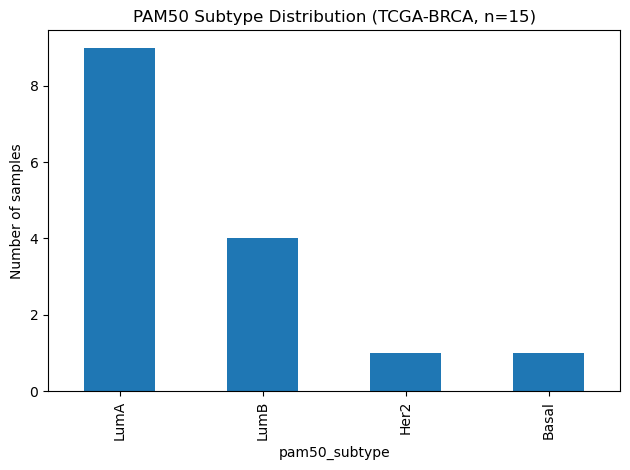

In [13]:
import matplotlib.pyplot as plt

counts = labels["pam50_subtype"].value_counts()

counts.plot(kind="bar")
plt.title("PAM50 Subtype Distribution (TCGA-BRCA, n=15)")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()


## Preliminary Observations

- All 50 PAM50 genes were successfully matched
- Intrinsic subtyping ran without missing probes
- Subtype distribution is biologically plausible
- Pipeline is validated and ready for:
  - Scaling to full TCGA-BRCA
  - Other cancers (Colon, Lung, etc.)
  - Integration with H&E whole-slide images


## Why This Matters

This pipeline establishes a reproducible RNA-derived molecular ground truth
that can be directly aligned with histopathology images for
image-based subtype prediction.

The same structure generalizes to other cancer types.
